# Arabic WordNet Quality Evaluation

**A Comprehensive Evaluation Framework for Linguists**

This notebook provides a systematic assessment of the Arabic WordNet (AWN v2) quality across multiple dimensions:

| Part | Focus Area | Sections |
|------|------------|----------|
| I | Coverage Analysis | Lexical, Domain, Core Vocabulary |
| II | Structural Quality | Taxonomy, Relations, Consistency |
| III | Linguistic Quality | Polysemy, Synonyms, Definitions, Morphology |
| IV | Cross-Lingual Alignment | ILI Mapping, Translation Accuracy |
| V | Data Quality Issues | Duplicates, Encoding, Completeness |
| VI | Manual Review Samples | Stratified Samples, Annotation Templates |
| VII | Summary & Recommendations | Quality Metrics, Export All |

All analysis results are exported to CSV/JSON files in the `exports/` directory for offline review.

---
## Section 1: Setup & Configuration

In [1]:
# Install required dependencies
# Uncomment and run if needed

!pip install --upgrade wn pandas matplotlib seaborn numpy
!pip install camel-tools
!camel_data -i light  # Download CAMeL data (light version)

  Using cached pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached numpy-2.4.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (6.6 kB)
Using cached pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl (10.7 MB)
Using cached numpy-2.4.1-cp312-cp312-macosx_14_0_arm64.whl (5.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
  Attempting uninstall: pandas━━━━━━━━━━━━━━━━━━━━━━━━ 0/3 [numpy]
    Found existing installation: pandas 2.2.3━━━━━ 0/3 [numpy]
    Uninstalling pandas-2.2.3:━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [pandas]
      Successfully uninstalled pandas-2.2.37m╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [pandas]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [seaborn]━━━━━━━━━━ 2/3 [seaborn]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-in

In [2]:
import wn
from wn import taxonomy, similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import json
import os
import unicodedata
import re
import warnings
from pathlib import Path
import random

warnings.filterwarnings('ignore')

# Set display options for Arabic text
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 100)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"wn version: {wn.__version__}")

wn version: 0.14.0


In [3]:
# Create exports directory
EXPORT_DIR = Path('exports')
EXPORT_DIR.mkdir(exist_ok=True)

print(f"Export directory: {EXPORT_DIR.absolute()}")

Export directory: /Users/salahmac/Desktop/MLProjects/wn-project/wn/notebooks/exports


In [4]:
# Download required wordnets
print("Downloading Arabic WordNet...")
wn.download('omw-arb:1.4')

print("\nDownloading English WordNet...")
wn.download('omw-en:1.4')

print("\nDownloading Open English WordNet (for richer relations)...")
wn.download('oewn:2024')

Cached file found: /Users/salahmac/.wn_data/downloads/4cb8d2182ddb97c9a9d865fe4b0fd7c7a74d6a21
Skipping omw-arb:1.4 (Arabic WordNet (AWN v2)); already addedoa9gu8gz/omw-arb/omw-arb.xml

Cached file found: /Users/salahmac/.wn_data/downloads/3334cfd8709f5032fe246261d73528528c2542fa
Skipping omw-en:1.4 (OMW English Wordnet based on WordNet 3.0); already addedomw-en.xml

Download (0 bytes) Requesting

Download [##############################] (12912114/12912114 bytes) Completeg
Read [##############################] (1298444/1298444) n/T/tmpeu1vvtk1.xmll
Added oewn:2024 (Open Engish Wordnet)] (1295226/1295226) Examplesonsionssurs



PosixPath('/Users/salahmac/.wn_data/downloads/cc34c0f3eb82b482b7e4ca46bce18467dd59b243')

In [6]:
# Initialize WordNet instances
arb = wn.Wordnet('omw-arb:1.4')
arb_expanded = wn.Wordnet('omw-arb:1.4', expand='omw-en:1.4')
en = wn.Wordnet('omw-en:1.4')

# Get lexicon info
arb_lex = arb.lexicons()[0]

print("Loaded WordNets:")
for lex in wn.lexicons():
    print(f"  {lex.id:15} v{lex.version:5} [{lex.language:3}] {lex.label}")

Loaded WordNets:
  omw-arb         v1.4   [arb] Arabic WordNet (AWN v2)
  omw-en          v1.4   [en ] OMW English Wordnet based on WordNet 3.0
  ewn             v2020  [en ] English WordNet
  test-lex        v1.0   [en ] Test Lexicon
  test-lex-v2     v1.0   [en ] Test Lexicon V2
  test-fe25e5     v1.0   [en ] Test
  oewn            v2024  [en ] Open Engish Wordnet


In [7]:
# Helper functions

def get_definition(synset, en_wordnet=None):
    """Get definition for a synset, falling back to English if Arabic is missing."""
    defn = synset.definition()
    if defn:
        return defn, 'ar'
    
    if en_wordnet and synset.ili:
        en_synsets = en_wordnet.synsets(ili=synset.ili.id)
        if en_synsets:
            en_defn = en_synsets[0].definition()
            if en_defn:
                return en_defn, 'en'
    
    return "(no definition)", None

def get_english_words(synset, en_wordnet):
    """Get English word equivalents for an Arabic synset via ILI."""
    if synset.ili:
        en_synsets = en_wordnet.synsets(ili=synset.ili.id)
        if en_synsets:
            return [w.lemma() for w in en_synsets[0].words()]
    return []

def export_df(df, filename, index=False):
    """Export DataFrame to CSV with UTF-8 encoding."""
    filepath = EXPORT_DIR / filename
    df.to_csv(filepath, index=index, encoding='utf-8-sig')  # utf-8-sig for Excel compatibility
    print(f"Exported: {filepath} ({len(df)} rows)")
    return filepath

def export_json(data, filename):
    """Export data to JSON with UTF-8 encoding."""
    filepath = EXPORT_DIR / filename
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"Exported: {filepath}")
    return filepath

print("Helper functions defined.")

Helper functions defined.


---
## Section 2: Executive Summary Dashboard

In [8]:
# Collect high-level metrics
def collect_summary_metrics():
    """Collect all high-level metrics for the dashboard."""
    metrics = {
        'lexicon_id': arb_lex.id,
        'version': arb_lex.version,
        'language': arb_lex.language,
        'total_words': len(list(arb.words())),
        'total_senses': len(list(arb.senses())),
        'total_synsets': len(list(arb.synsets())),
    }
    
    # By POS
    for pos in ['n', 'v', 'a', 'r', 's']:
        metrics[f'words_{pos}'] = len(list(arb.words(pos=pos)))
        metrics[f'synsets_{pos}'] = len(list(arb.synsets(pos=pos)))
    
    # ILI coverage
    synsets_with_ili = sum(1 for ss in arb.synsets() if ss.ili)
    metrics['synsets_with_ili'] = synsets_with_ili
    metrics['ili_coverage_pct'] = synsets_with_ili / metrics['total_synsets'] * 100
    
    # Definition coverage
    synsets_with_def = sum(1 for ss in arb.synsets() if ss.definition())
    metrics['synsets_with_definition'] = synsets_with_def
    metrics['definition_coverage_pct'] = synsets_with_def / metrics['total_synsets'] * 100
    
    return metrics

summary_metrics = collect_summary_metrics()

In [9]:
# Display Executive Summary
print("=" * 70)
print("                 ARABIC WORDNET QUALITY EVALUATION")
print("                      Executive Summary Dashboard")
print("=" * 70)
print(f"\nLexicon: {summary_metrics['lexicon_id']} v{summary_metrics['version']}")
print(f"Language: {summary_metrics['language']}")
print()

print("-" * 70)
print("COVERAGE METRICS")
print("-" * 70)
print(f"{'Total Words:':<30} {summary_metrics['total_words']:>10,}")
print(f"{'Total Senses:':<30} {summary_metrics['total_senses']:>10,}")
print(f"{'Total Synsets:':<30} {summary_metrics['total_synsets']:>10,}")
print()

print("-" * 70)
print("BY PART OF SPEECH")
print("-" * 70)
pos_names = {'n': 'Nouns', 'v': 'Verbs', 'a': 'Adjectives', 'r': 'Adverbs', 's': 'Adj. Satellites'}
for pos, name in pos_names.items():
    words = summary_metrics[f'words_{pos}']
    synsets = summary_metrics[f'synsets_{pos}']
    print(f"{name + ':':<20} {words:>8,} words, {synsets:>8,} synsets")
print()

print("-" * 70)
print("QUALITY INDICATORS")
print("-" * 70)
print(f"{'ILI Coverage:':<30} {summary_metrics['ili_coverage_pct']:>9.1f}%")
print(f"{'Definition Coverage:':<30} {summary_metrics['definition_coverage_pct']:>9.1f}%")
print("=" * 70)

                 ARABIC WORDNET QUALITY EVALUATION
                      Executive Summary Dashboard

Lexicon: omw-arb v1.4
Language: arb

----------------------------------------------------------------------
COVERAGE METRICS
----------------------------------------------------------------------
Total Words:                       18,003
Total Senses:                      37,342
Total Synsets:                      9,916

----------------------------------------------------------------------
BY PART OF SPEECH
----------------------------------------------------------------------
Nouns:                 10,344 words,    6,884 synsets
Verbs:                  6,728 words,    2,484 synsets
Adjectives:               693 words,      443 synsets
Adverbs:                  238 words,      105 synsets
Adj. Satellites:            0 words,        0 synsets

----------------------------------------------------------------------
QUALITY INDICATORS
------------------------------------------------------

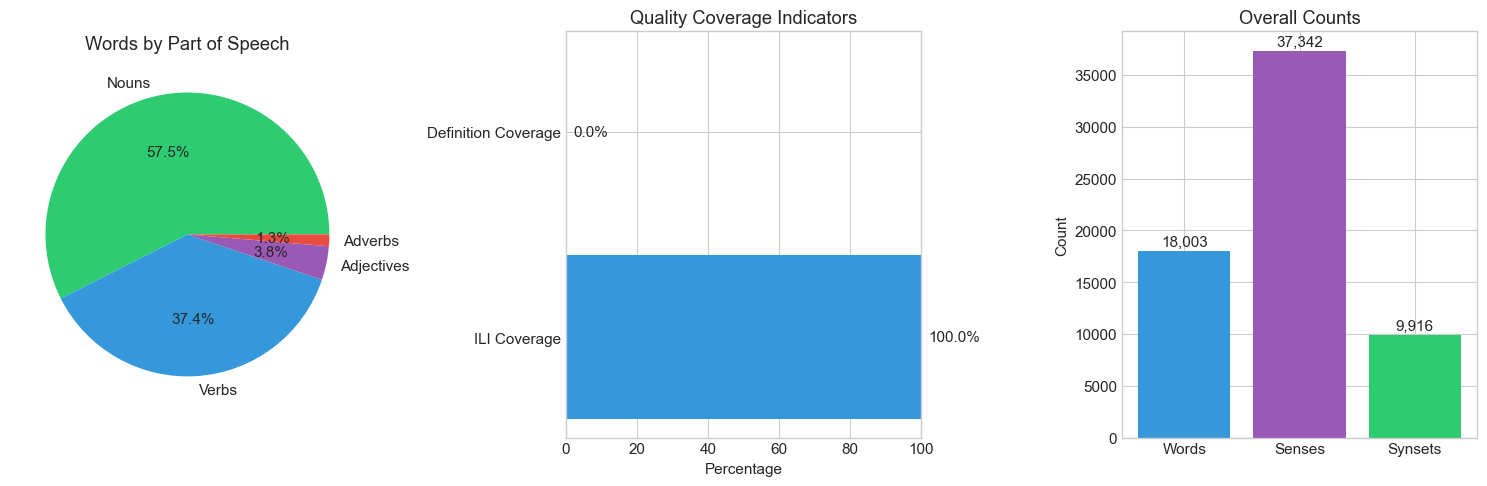

In [10]:
# Visual summary
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# POS distribution
pos_data = {pos_names[p]: summary_metrics[f'words_{p}'] for p in ['n', 'v', 'a', 'r']}
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
axes[0].pie(pos_data.values(), labels=pos_data.keys(), autopct='%1.1f%%', colors=colors)
axes[0].set_title('Words by Part of Speech')

# Coverage indicators
coverage_data = ['ILI Coverage', 'Definition Coverage']
coverage_values = [summary_metrics['ili_coverage_pct'], summary_metrics['definition_coverage_pct']]
bars = axes[1].barh(coverage_data, coverage_values, color=['#3498db', '#2ecc71'])
axes[1].set_xlim(0, 100)
axes[1].set_xlabel('Percentage')
axes[1].set_title('Quality Coverage Indicators')
for bar, val in zip(bars, coverage_values):
    axes[1].text(val + 2, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center')

# Words vs Synsets
x = ['Words', 'Senses', 'Synsets']
y = [summary_metrics['total_words'], summary_metrics['total_senses'], summary_metrics['total_synsets']]
axes[2].bar(x, y, color=['#3498db', '#9b59b6', '#2ecc71'])
axes[2].set_ylabel('Count')
axes[2].set_title('Overall Counts')
for i, v in enumerate(y):
    axes[2].text(i, v + 500, f'{v:,}', ha='center')

plt.tight_layout()
plt.savefig(EXPORT_DIR / 'executive_summary.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part I: Coverage Analysis

## Section 3: Lexical Coverage

In [11]:
# Detailed coverage analysis
print("Lexical Coverage Analysis")
print("=" * 60)

# Arabic stats
arb_words = list(arb.words())
arb_senses = list(arb.senses())
arb_synsets = list(arb.synsets())

# English stats for comparison
en_words = list(en.words())
en_senses = list(en.senses())
en_synsets = list(en.synsets())

coverage_data = []

# Overall
coverage_data.append({
    'Category': 'All',
    'Arabic_Words': len(arb_words),
    'Arabic_Senses': len(arb_senses),
    'Arabic_Synsets': len(arb_synsets),
    'English_Words': len(en_words),
    'English_Senses': len(en_senses),
    'English_Synsets': len(en_synsets),
    'Coverage_Pct': len(arb_synsets) / len(en_synsets) * 100
})

# By POS
for pos, name in pos_names.items():
    arb_w = len(list(arb.words(pos=pos)))
    arb_se = len(list(arb.senses(pos=pos)))
    arb_sy = len(list(arb.synsets(pos=pos)))
    en_w = len(list(en.words(pos=pos)))
    en_se = len(list(en.senses(pos=pos)))
    en_sy = len(list(en.synsets(pos=pos)))
    
    coverage_data.append({
        'Category': name,
        'Arabic_Words': arb_w,
        'Arabic_Senses': arb_se,
        'Arabic_Synsets': arb_sy,
        'English_Words': en_w,
        'English_Senses': en_se,
        'English_Synsets': en_sy,
        'Coverage_Pct': arb_sy / en_sy * 100 if en_sy > 0 else 0
    })

coverage_df = pd.DataFrame(coverage_data)
print(coverage_df.to_string(index=False))

export_df(coverage_df, 'coverage_summary.csv')

Lexical Coverage Analysis
       Category  Arabic_Words  Arabic_Senses  Arabic_Synsets  English_Words  English_Senses  English_Synsets  Coverage_Pct
            All         18003          37342            9916         156584          206978           117659      8.427745
          Nouns         10344          14239            6884         119034          146347            82115      8.383365
          Verbs          6728          22094            2484          11531           25047            13767     18.043147
     Adjectives           693            757             443          21538           30004             7463      5.935951
        Adverbs           238            252             105           4481            5580             3621      2.899751
Adj. Satellites             0              0               0              0               0            10693      0.000000
Exported: exports/coverage_summary.csv (6 rows)


PosixPath('exports/coverage_summary.csv')

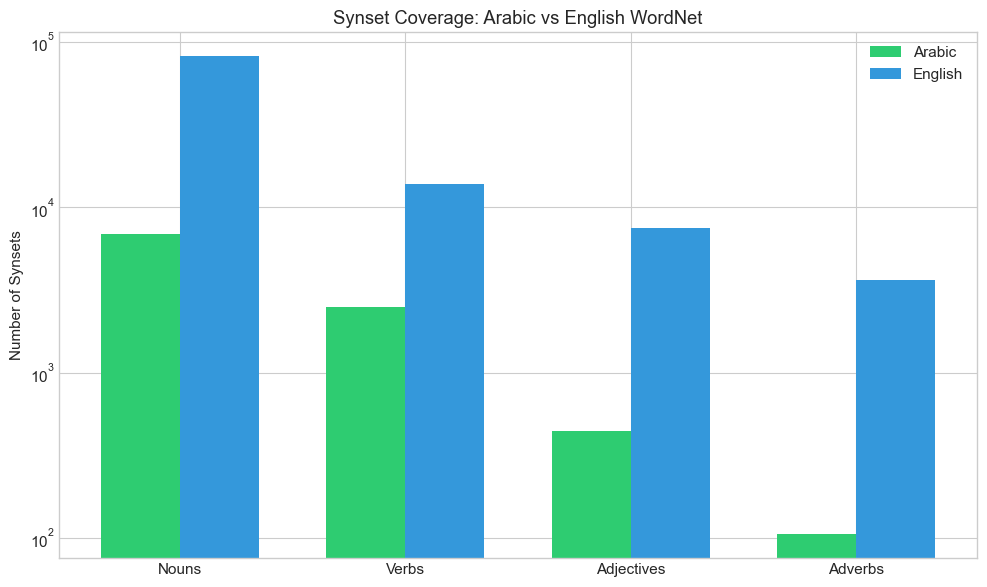

In [12]:
# Visualize coverage comparison
fig, ax = plt.subplots(figsize=(10, 6))

pos_list = ['Nouns', 'Verbs', 'Adjectives', 'Adverbs']
arb_counts = [coverage_df[coverage_df['Category'] == p]['Arabic_Synsets'].values[0] for p in pos_list]
en_counts = [coverage_df[coverage_df['Category'] == p]['English_Synsets'].values[0] for p in pos_list]

x = np.arange(len(pos_list))
width = 0.35

bars1 = ax.bar(x - width/2, arb_counts, width, label='Arabic', color='#2ecc71')
bars2 = ax.bar(x + width/2, en_counts, width, label='English', color='#3498db')

ax.set_ylabel('Number of Synsets')
ax.set_title('Synset Coverage: Arabic vs English WordNet')
ax.set_xticks(x)
ax.set_xticklabels(pos_list)
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.savefig(EXPORT_DIR / 'coverage_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Section 4: Domain Coverage Analysis

In [13]:
# Analyze domain/topic coverage using domain relations
print("Domain Coverage Analysis")
print("=" * 60)

domain_counts = Counter()
synsets_with_domain = 0

for ss in arb_expanded.synsets():
    relations = ss.relations()
    
    # Check for domain_topic relation
    if 'domain_topic' in relations:
        synsets_with_domain += 1
        for domain_ss in relations['domain_topic']:
            # Get domain name
            domain_words = [w.lemma() for w in domain_ss.words()]
            if domain_words:
                domain_counts[domain_words[0]] += 1
            else:
                # Try English
                en_words = get_english_words(domain_ss, en)
                if en_words:
                    domain_counts[f"[{en_words[0]}]"] += 1

print(f"Synsets with domain tags: {synsets_with_domain} ({synsets_with_domain/len(arb_synsets)*100:.1f}%)")
print(f"\nTop 20 domains:")

domain_data = [{'Domain': domain, 'Count': count} for domain, count in domain_counts.most_common(30)]
domain_df = pd.DataFrame(domain_data)

if len(domain_df) > 0:
    print(domain_df.head(20).to_string(index=False))
    export_df(domain_df, 'domain_coverage.csv')
else:
    print("No domain tags found in the Arabic WordNet.")

Domain Coverage Analysis
Synsets with domain tags: 629 (6.3%)

Top 20 domains:
                    Domain  Count
                     عسْكر    113
                    قانُون     51
           عِلْم الكِيمياء     48
الفَلْسَفَة  الطَبِيعِيَّة     27
                    تِجارة     24
            عِلْم الأحْياء     21
                رِياضِيّات     19
             إِنْتاج فنِّي     13
                   إِعْداد     12
                [medicine]     12
                    أعْمال     11
                 مُوسِيق?ى     11
        [computer science]     11
          العَهْد القَدِيم      9
                    دِيانة      8
                 [zoology]      8
         [Greek mythology]      7
        فُنُون التَّمْثِيل      7
                [baseball]      7
          ألْعاب رِياضِيّة      7
Exported: exports/domain_coverage.csv (30 rows)


## Section 5: Core Vocabulary Coverage

In [14]:
# Arabic Swadesh list (basic vocabulary - subset)
# These are core concepts that should be in any comprehensive wordnet

swadesh_arabic = {
    'I/me': 'أنا',
    'you': 'أنت',
    'we': 'نحن',
    'this': 'هذا',
    'that': 'ذلك',
    'who': 'من',
    'what': 'ما',
    'not': 'لا',
    'all': 'كل',
    'many': 'كثير',
    'one': 'واحد',
    'two': 'اثنان',
    'big': 'كبير',
    'long': 'طويل',
    'small': 'صغير',
    'woman': 'امرأة',
    'man': 'رجل',
    'person': 'شخص',
    'fish': 'سمك',
    'bird': 'طائر',
    'dog': 'كلب',
    'tree': 'شجرة',
    'seed': 'بذرة',
    'leaf': 'ورقة',
    'root': 'جذر',
    'skin': 'جلد',
    'blood': 'دم',
    'bone': 'عظم',
    'egg': 'بيضة',
    'horn': 'قرن',
    'tail': 'ذيل',
    'feather': 'ريشة',
    'hair': 'شعر',
    'head': 'رأس',
    'ear': 'أذن',
    'eye': 'عين',
    'nose': 'أنف',
    'mouth': 'فم',
    'tooth': 'سن',
    'tongue': 'لسان',
    'hand': 'يد',
    'foot': 'قدم',
    'heart': 'قلب',
    'liver': 'كبد',
    'water': 'ماء',
    'fire': 'نار',
    'sun': 'شمس',
    'moon': 'قمر',
    'star': 'نجم',
    'earth': 'أرض',
    'stone': 'حجر',
    'sand': 'رمل',
    'mountain': 'جبل',
    'night': 'ليل',
    'day': 'يوم',
    'year': 'سنة',
    'name': 'اسم',
    'eat': 'أكل',
    'drink': 'شرب',
    'sleep': 'نام',
    'die': 'مات',
    'kill': 'قتل',
    'walk': 'مشى',
    'come': 'جاء',
    'go': 'ذهب',
    'see': 'رأى',
    'hear': 'سمع',
    'know': 'عرف',
    'think': 'فكر',
    'say': 'قال',
    'give': 'أعطى',
}

print("Core Vocabulary (Swadesh List) Coverage Analysis")
print("=" * 60)

vocab_results = []
found_count = 0
missing = []

for english, arabic in swadesh_arabic.items():
    words = arb.words(arabic)
    found = len(words) > 0
    
    if found:
        found_count += 1
        num_senses = sum(len(w.senses()) for w in words)
    else:
        missing.append((english, arabic))
        num_senses = 0
    
    vocab_results.append({
        'English': english,
        'Arabic': arabic,
        'Found': 'Yes' if found else 'No',
        'Num_Senses': num_senses
    })

vocab_df = pd.DataFrame(vocab_results)

print(f"Coverage: {found_count}/{len(swadesh_arabic)} ({found_count/len(swadesh_arabic)*100:.1f}%)")
print(f"\nMissing core vocabulary ({len(missing)} items):")
for eng, arb_word in missing[:20]:
    print(f"  {eng}: {arb_word}")

export_df(vocab_df, 'vocabulary_gaps.csv')

Core Vocabulary (Swadesh List) Coverage Analysis
Coverage: 62/71 (87.3%)

Missing core vocabulary (9 items):
  you: أنت
  we: نحن
  this: هذا
  that: ذلك
  who: من
  what: ما
  long: طويل
  feather: ريشة
  nose: أنف
Exported: exports/vocabulary_gaps.csv (71 rows)


PosixPath('exports/vocabulary_gaps.csv')

---
# Part II: Structural Quality

## Section 6: Taxonomy Analysis

In [15]:
# Taxonomy depth analysis
print("Taxonomy Depth Analysis")
print("=" * 60)

def analyze_taxonomy_depth(wordnet, pos='n', sample_size=None):
    """Analyze taxonomy depth distribution."""
    synsets = list(wordnet.synsets(pos=pos))
    if sample_size and len(synsets) > sample_size:
        synsets = random.sample(synsets, sample_size)
    
    depths = []
    orphans = []  # Synsets with no hypernyms (except roots)
    
    for ss in synsets:
        try:
            depth = taxonomy.min_depth(ss)
            depths.append(depth)
            
            # Check for orphans (depth 0 but not a root)
            if depth == 0:
                hyponyms = ss.hyponyms()
                if not hyponyms:  # No children either
                    orphans.append(ss)
        except:
            pass
    
    return depths, orphans

# Analyze nouns
noun_depths, noun_orphans = analyze_taxonomy_depth(arb_expanded, 'n')
verb_depths, verb_orphans = analyze_taxonomy_depth(arb_expanded, 'v')

print(f"Noun Taxonomy:")
print(f"  Synsets analyzed: {len(noun_depths)}")
print(f"  Max depth: {max(noun_depths) if noun_depths else 0}")
print(f"  Avg depth: {np.mean(noun_depths):.2f}" if noun_depths else "  Avg depth: N/A")
print(f"  Orphan synsets: {len(noun_orphans)}")

print(f"\nVerb Taxonomy:")
print(f"  Synsets analyzed: {len(verb_depths)}")
print(f"  Max depth: {max(verb_depths) if verb_depths else 0}")
print(f"  Avg depth: {np.mean(verb_depths):.2f}" if verb_depths else "  Avg depth: N/A")
print(f"  Orphan synsets: {len(verb_orphans)}")

Taxonomy Depth Analysis
Noun Taxonomy:
  Synsets analyzed: 6884
  Max depth: 17
  Avg depth: 6.71
  Orphan synsets: 0

Verb Taxonomy:
  Synsets analyzed: 2484
  Max depth: 9
  Avg depth: 1.99
  Orphan synsets: 57


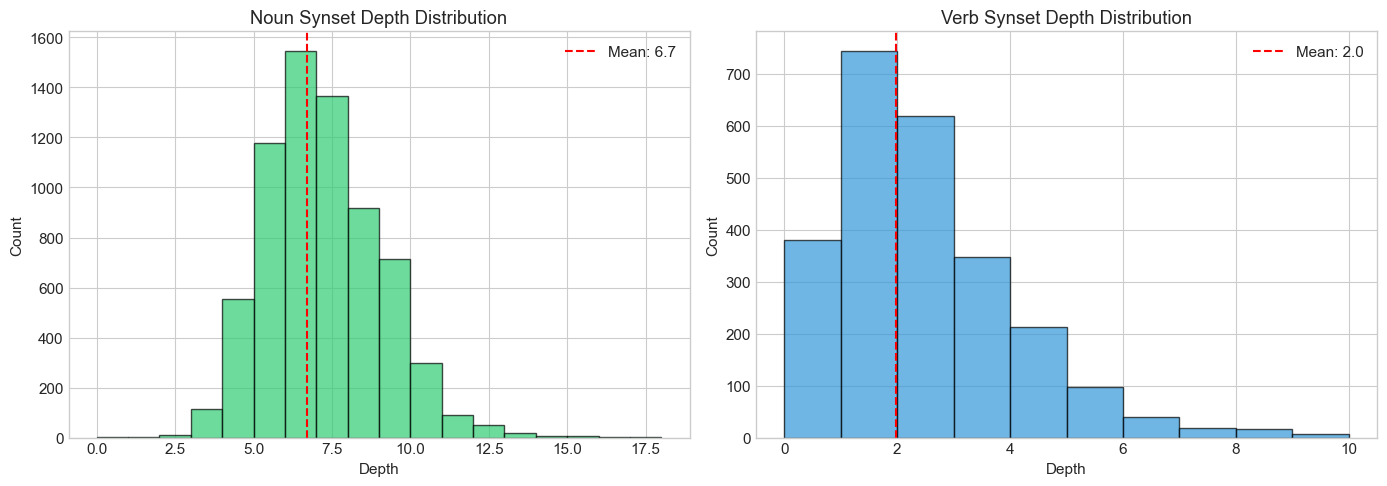

In [16]:
# Visualize depth distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if noun_depths:
    axes[0].hist(noun_depths, bins=range(max(noun_depths)+2), edgecolor='black', alpha=0.7, color='#2ecc71')
    axes[0].set_xlabel('Depth')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Noun Synset Depth Distribution')
    axes[0].axvline(np.mean(noun_depths), color='red', linestyle='--', label=f'Mean: {np.mean(noun_depths):.1f}')
    axes[0].legend()

if verb_depths:
    axes[1].hist(verb_depths, bins=range(max(verb_depths)+2), edgecolor='black', alpha=0.7, color='#3498db')
    axes[1].set_xlabel('Depth')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Verb Synset Depth Distribution')
    axes[1].axvline(np.mean(verb_depths), color='red', linestyle='--', label=f'Mean: {np.mean(verb_depths):.1f}')
    axes[1].legend()

plt.tight_layout()
plt.savefig(EXPORT_DIR / 'taxonomy_depth.png', dpi=150, bbox_inches='tight')
plt.show()

## Section 7: Relation Distribution

In [17]:
# Analyze relation types and their distribution
print("Relation Distribution Analysis")
print("=" * 60)

relation_counts = Counter()
synsets_by_relation_count = Counter()

for ss in arb_expanded.synsets():
    relations = ss.relations()
    total_relations = 0
    
    for rel_type, related in relations.items():
        relation_counts[rel_type] += len(related)
        total_relations += len(related)
    
    synsets_by_relation_count[total_relations] += 1

print("Relation type distribution:")
print("-" * 40)

relation_data = []
for rel_type, count in relation_counts.most_common():
    relation_data.append({'Relation_Type': rel_type, 'Count': count})
    print(f"  {rel_type:25} {count:>8,}")

relation_df = pd.DataFrame(relation_data)
export_df(relation_df, 'relation_statistics.csv')

print(f"\nSynsets with 0 relations: {synsets_by_relation_count.get(0, 0)}")
print(f"Average relations per synset: {sum(relation_counts.values()) / len(arb_synsets):.2f}")

Relation Distribution Analysis
Relation type distribution:
----------------------------------------
  hyponym                     51,839
  hypernym                     8,649
  instance_hyponym             5,513
  has_domain_topic             3,959
  mero_part                    3,476
  similar                      2,204
  mero_member                  1,805
  holo_part                    1,184
  has_domain_region            1,047
  domain_topic                   668
  instance_hypernym              623
  holo_member                    517
  attribute                      399
  also                           304
  holo_substance                 200
  entails                        147
  mero_substance                 125
  causes                          93
  is_exemplified_by               54
  domain_region                   39
  exemplifies                      9
Exported: exports/relation_statistics.csv (21 rows)

Synsets with 0 relations: 298
Average relations per synset: 8.36


## Section 8: Structural Consistency Checks

In [18]:
# Structural consistency checks
print("Structural Consistency Checks")
print("=" * 60)

issues = []

# Check for synsets with no words
empty_synsets = []
for ss in arb.synsets():
    if not ss.words():
        empty_synsets.append(ss.id)
        issues.append({'Issue_Type': 'Empty_Synset', 'ID': ss.id, 'Details': 'Synset has no words'})

print(f"Synsets with no words: {len(empty_synsets)}")

# Check for words with no senses
words_no_senses = []
for word in arb.words():
    if not word.senses():
        words_no_senses.append(word.lemma())
        issues.append({'Issue_Type': 'Word_No_Senses', 'ID': word.lemma(), 'Details': 'Word has no senses'})

print(f"Words with no senses: {len(words_no_senses)}")

# Check for isolated synsets (no relations at all)
isolated_synsets = []
for ss in arb_expanded.synsets():
    relations = ss.relations()
    if not relations:
        isolated_synsets.append(ss.id)
        issues.append({'Issue_Type': 'Isolated_Synset', 'ID': ss.id, 'Details': 'No relations'})

print(f"Isolated synsets (no relations): {len(isolated_synsets)}")

# Check for synsets without ILI
no_ili = []
for ss in arb.synsets():
    if not ss.ili:
        no_ili.append(ss.id)
        issues.append({'Issue_Type': 'No_ILI', 'ID': ss.id, 'Details': 'Missing ILI link'})

print(f"Synsets without ILI link: {len(no_ili)}")

# Export issues
issues_df = pd.DataFrame(issues)
if len(issues_df) > 0:
    export_df(issues_df, 'structural_issues.csv')
    
print(f"\nTotal structural issues found: {len(issues)}")

Structural Consistency Checks
Synsets with no words: 0
Words with no senses: 0
Isolated synsets (no relations): 298
Synsets without ILI link: 0
Exported: exports/structural_issues.csv (298 rows)

Total structural issues found: 298


---
# Part III: Linguistic Quality

## Section 9: Polysemy Analysis

In [19]:
# Polysemy analysis
print("Polysemy Analysis")
print("=" * 60)

def analyze_polysemy(wordnet, pos=None):
    """Analyze polysemy patterns."""
    words = list(wordnet.words(pos=pos))
    sense_counts = [len(w.senses()) for w in words]
    
    return {
        'total_words': len(words),
        'monosemous': sum(1 for c in sense_counts if c == 1),
        'polysemous': sum(1 for c in sense_counts if c > 1),
        'highly_polysemous': sum(1 for c in sense_counts if c >= 5),
        'avg_senses': np.mean(sense_counts) if sense_counts else 0,
        'max_senses': max(sense_counts) if sense_counts else 0,
        'distribution': Counter(sense_counts)
    }

# Overall polysemy
overall_poly = analyze_polysemy(arb)

print(f"Overall Polysemy:")
print(f"  Total words: {overall_poly['total_words']:,}")
print(f"  Monosemous (1 sense): {overall_poly['monosemous']:,} ({overall_poly['monosemous']/overall_poly['total_words']*100:.1f}%)")
print(f"  Polysemous (>1 sense): {overall_poly['polysemous']:,} ({overall_poly['polysemous']/overall_poly['total_words']*100:.1f}%)")
print(f"  Highly polysemous (>=5): {overall_poly['highly_polysemous']:,}")
print(f"  Average senses/word: {overall_poly['avg_senses']:.2f}")
print(f"  Maximum senses: {overall_poly['max_senses']}")

# By POS
print("\nPolysemy by Part of Speech:")
print("-" * 60)
for pos, name in [('n', 'Nouns'), ('v', 'Verbs'), ('a', 'Adjectives'), ('r', 'Adverbs')]:
    poly = analyze_polysemy(arb, pos)
    if poly['total_words'] > 0:
        print(f"  {name}: avg {poly['avg_senses']:.2f} senses, max {poly['max_senses']}, {poly['highly_polysemous']} highly polysemous")

Polysemy Analysis
Overall Polysemy:
  Total words: 18,003
  Monosemous (1 sense): 12,591 (69.9%)
  Polysemous (>1 sense): 5,412 (30.1%)
  Highly polysemous (>=5): 1,424
  Average senses/word: 2.07
  Maximum senses: 48

Polysemy by Part of Speech:
------------------------------------------------------------
  Nouns: avg 1.38 senses, max 18, 240 highly polysemous
  Verbs: avg 3.28 senses, max 48, 1184 highly polysemous
  Adjectives: avg 1.09 senses, max 3, 0 highly polysemous
  Adverbs: avg 1.06 senses, max 2, 0 highly polysemous


In [20]:
# Most polysemous words
print("\nMost Polysemous Words (potential over-splitting):")
print("=" * 60)

word_senses = [(w, len(w.senses())) for w in arb.words()]
word_senses.sort(key=lambda x: x[1], reverse=True)

poly_data = []
for word, num_senses in word_senses[:30]:
    en_equiv = []
    for sense in word.senses()[:1]:  # Get one English equivalent
        en_words = get_english_words(sense.synset(), en)
        if en_words:
            en_equiv = en_words[:3]
    
    poly_data.append({
        'Arabic_Word': word.lemma(),
        'POS': word.pos,
        'Num_Senses': num_senses,
        'English_Equiv': ', '.join(en_equiv)
    })
    print(f"  {word.lemma():25} ({word.pos}) - {num_senses} senses")

poly_df = pd.DataFrame(poly_data)
export_df(poly_df, 'highly_polysemous_words.csv')


Most Polysemous Words (potential over-splitting):
  أدرك                      (v) - 48 senses
  أثار                      (v) - 47 senses
  فصل                       (v) - 46 senses
  حمل                       (v) - 45 senses
  حقق                       (v) - 45 senses
  رافق                      (v) - 44 senses
  حول                       (v) - 43 senses
  نشر                       (v) - 42 senses
  حدث                       (v) - 41 senses
  ظهر                       (v) - 41 senses
  ترك                       (v) - 41 senses
  عبر                       (v) - 39 senses
  رحل                       (v) - 39 senses
  وقع                       (v) - 39 senses
  فهم                       (v) - 38 senses
  وصل                       (v) - 37 senses
  عرض                       (v) - 36 senses
  أضعف                      (v) - 36 senses
  أنتج                      (v) - 36 senses
  اعتبر                     (v) - 36 senses
  شغل                       (v) - 35 senses
  استمر                  

PosixPath('exports/highly_polysemous_words.csv')

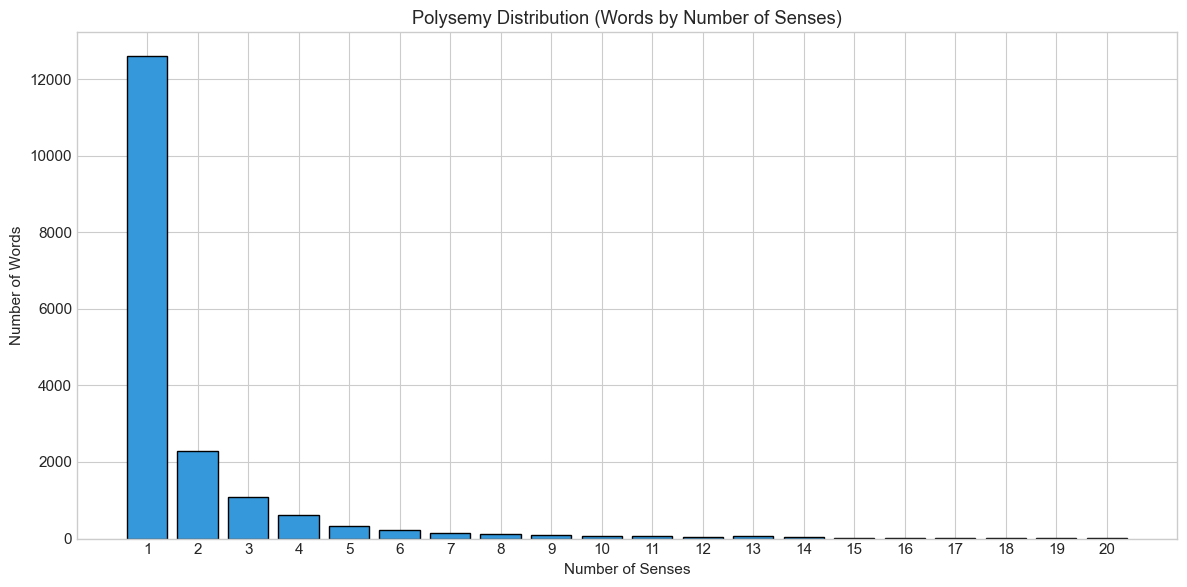

In [21]:
# Polysemy distribution visualization
fig, ax = plt.subplots(figsize=(12, 6))

sense_dist = overall_poly['distribution']
x = sorted([k for k in sense_dist.keys() if k <= 20])  # Limit to 20 for visualization
y = [sense_dist[k] for k in x]

ax.bar(x, y, color='#3498db', edgecolor='black')
ax.set_xlabel('Number of Senses')
ax.set_ylabel('Number of Words')
ax.set_title('Polysemy Distribution (Words by Number of Senses)')
ax.set_xticks(x)

plt.tight_layout()
plt.savefig(EXPORT_DIR / 'polysemy_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## Section 10: Synonym Set Quality

In [22]:
# Synset size analysis
print("Synonym Set (Synset) Size Analysis")
print("=" * 60)

synset_sizes = []
large_synsets = []  # Synsets with many words (potential lumping)
singleton_synsets = []  # Single-word synsets

for ss in arb.synsets():
    words = ss.words()
    size = len(words)
    synset_sizes.append(size)
    
    if size >= 10:
        large_synsets.append((ss, size))
    elif size == 1:
        singleton_synsets.append(ss)

size_dist = Counter(synset_sizes)

print(f"Total synsets: {len(synset_sizes):,}")
print(f"Singleton synsets (1 word): {len(singleton_synsets):,} ({len(singleton_synsets)/len(synset_sizes)*100:.1f}%)")
print(f"Large synsets (>=10 words): {len(large_synsets):,}")
print(f"Average synset size: {np.mean(synset_sizes):.2f}")
print(f"Maximum synset size: {max(synset_sizes)}")

print("\nSynset size distribution:")
for size in sorted(size_dist.keys())[:15]:
    count = size_dist[size]
    bar = '#' * min(count // 50, 40)
    print(f"  {size:3} words: {count:5} synsets {bar}")

Synonym Set (Synset) Size Analysis
Total synsets: 9,916
Singleton synsets (1 word): 3,684 (37.2%)
Large synsets (>=10 words): 782
Average synset size: 3.77
Maximum synset size: 83

Synset size distribution:
    1 words:  3684 synsets ########################################
    2 words:  2523 synsets ########################################
    3 words:  1333 synsets ##########################
    4 words:   717 synsets ##############
    5 words:   367 synsets #######
    6 words:   199 synsets ###
    7 words:   134 synsets ##
    8 words:    94 synsets #
    9 words:    83 synsets #
   10 words:    82 synsets #
   11 words:    61 synsets #
   12 words:    58 synsets #
   13 words:    59 synsets #
   14 words:    40 synsets 
   15 words:    50 synsets #


In [23]:
# Large synsets for review (potential lumping issues)
print("\nLargest Synsets (for review - potential over-lumping):")
print("=" * 70)

large_synsets.sort(key=lambda x: x[1], reverse=True)

synset_review_data = []
for ss, size in large_synsets[:20]:
    lemmas = [w.lemma() for w in ss.words()]
    defn, lang = get_definition(ss, en)
    en_words = get_english_words(ss, en)
    
    synset_review_data.append({
        'Synset_ID': ss.id,
        'Size': size,
        'POS': ss.pos,
        'Arabic_Words': '; '.join(lemmas[:10]) + ('...' if len(lemmas) > 10 else ''),
        'English_Equiv': ', '.join(en_words[:5]),
        'Definition': defn[:100]
    })
    
    print(f"\n[{size} words] {ss.id}")
    print(f"  Words: {', '.join(lemmas[:8])}{'...' if len(lemmas) > 8 else ''}")
    print(f"  Definition: {defn[:60]}..." if len(defn) > 60 else f"  Definition: {defn}")

synset_review_df = pd.DataFrame(synset_review_data)
export_df(synset_review_df, 'synset_samples_for_review.csv')


Largest Synsets (for review - potential over-lumping):

[83 words] omw-arb-01881180-v
  Words: شرد, طاف, هام, تجوّل, ترحّل, تسكّع, أضاع, أطلق...
  Definition: move about aimlessly or without any destination, often in se...

[81 words] omw-arb-02431320-v
  Words: اِنْفصل, أذاع, أرهق, أضعف, أفشى, أوقف, إستبدل قطع النقد, إنطلق بسرعة خاطفة...
  Definition: discontinue an association or relation; go different ways

[69 words] omw-arb-00770437-v
  Words: أغْرى, أقْنع, اِضْطرّ, حفّز, حثّ, دعى, جعل, سبّب...
  Definition: cause to do; cause to act in a specified manner

[69 words] omw-arb-01494310-v
  Words: أجبر العظم, أخرج, أخمد, أربك, أسس, ألقى اللوم على فلان, إنجبر للعظم, استثمر...
  Definition: put into a certain place or abstract location

[64 words] omw-arb-00358431-v
  Words: إِنْتهى, اِنْتقل إلى الرّفِيق الأعْلى, فنِي, هلك, لفظ النّفس الأخِير, مات, رحل, سلّم الرُّوح...
  Definition: pass from physical life and lose all bodily attributes and f...

[62 words] omw-arb-00933821-v
  Words:

PosixPath('exports/synset_samples_for_review.csv')

## Section 11: Definition Coverage & Quality

In [24]:
# Definition coverage analysis
print("Definition Coverage Analysis")
print("=" * 60)

def_stats = {
    'with_arabic_def': 0,
    'with_english_def': 0,
    'no_definition': 0,
    'def_lengths': []
}

definition_samples = []

for ss in arb.synsets():
    defn = ss.definition()
    
    if defn:
        def_stats['with_arabic_def'] += 1
        def_stats['def_lengths'].append(len(defn))
    else:
        # Check if English definition available
        en_def, lang = get_definition(ss, en)
        if lang == 'en':
            def_stats['with_english_def'] += 1
        else:
            def_stats['no_definition'] += 1
            definition_samples.append({
                'Synset_ID': ss.id,
                'Arabic_Words': ', '.join([w.lemma() for w in ss.words()][:5]),
                'Has_Arabic_Def': 'No',
                'Has_English_Def': 'No',
                'Issue': 'No definition available'
            })

total = len(arb_synsets)
print(f"Synsets with Arabic definition: {def_stats['with_arabic_def']:,} ({def_stats['with_arabic_def']/total*100:.1f}%)")
print(f"Synsets with English-only def:  {def_stats['with_english_def']:,} ({def_stats['with_english_def']/total*100:.1f}%)")
print(f"Synsets with no definition:     {def_stats['no_definition']:,} ({def_stats['no_definition']/total*100:.1f}%)")

if def_stats['def_lengths']:
    print(f"\nArabic definition length statistics:")
    print(f"  Average length: {np.mean(def_stats['def_lengths']):.1f} characters")
    print(f"  Min length: {min(def_stats['def_lengths'])} characters")
    print(f"  Max length: {max(def_stats['def_lengths'])} characters")

Definition Coverage Analysis
Synsets with Arabic definition: 0 (0.0%)
Synsets with English-only def:  9,916 (100.0%)
Synsets with no definition:     0 (0.0%)


In [25]:
# Sample definitions for quality review
print("\nSample Definitions for Quality Review:")
print("=" * 70)

# Get random sample of synsets with definitions
synsets_with_def = [ss for ss in arb.synsets() if ss.definition()]
sample_size = min(50, len(synsets_with_def))
sample_synsets = random.sample(synsets_with_def, sample_size) if synsets_with_def else []

for ss in sample_synsets:
    lemmas = [w.lemma() for w in ss.words()]
    en_words = get_english_words(ss, en)
    
    definition_samples.append({
        'Synset_ID': ss.id,
        'Arabic_Words': ', '.join(lemmas[:5]),
        'Arabic_Definition': ss.definition(),
        'English_Equiv': ', '.join(en_words[:3]),
        'Has_Arabic_Def': 'Yes',
        'Has_English_Def': 'Yes' if en_words else 'No'
    })

def_samples_df = pd.DataFrame(definition_samples)
export_df(def_samples_df, 'definition_samples.csv')

print(f"Exported {len(def_samples_df)} definition samples for review.")


Sample Definitions for Quality Review:
Exported: exports/definition_samples.csv (0 rows)
Exported 0 definition samples for review.


## Section 12: Advanced Morphological Analysis (CAMeL Tools)

In [26]:
# Try to import CAMeL Tools for morphological analysis
try:
    from camel_tools.morphology.database import MorphologyDB
    from camel_tools.morphology.analyzer import Analyzer
    from camel_tools.utils.normalize import normalize_unicode, normalize_alef_maksura_ar, normalize_alef_ar, normalize_teh_marbuta_ar
    from camel_tools.utils.dediac import dediac_ar
    
    CAMEL_AVAILABLE = True
    print("CAMeL Tools loaded successfully.")
    
    # Initialize morphological analyzer
    db = MorphologyDB.builtin_db()
    analyzer = Analyzer(db)
    print("Morphological analyzer initialized.")
    
except ImportError as e:
    CAMEL_AVAILABLE = False
    print(f"CAMeL Tools not available: {e}")
    print("Install with: pip install camel-tools && camel_data -i light")
    print("Morphological analysis will be limited.")

CAMeL Tools loaded successfully.
Morphological analyzer initialized.


In [27]:
# Basic morphological analysis (works without CAMeL)
print("Basic Morphological Analysis")
print("=" * 60)

# Diacritization analysis
def has_diacritics(text):
    """Check if text contains Arabic diacritics."""
    diacritics = set('\u064B\u064C\u064D\u064E\u064F\u0650\u0651\u0652\u0653\u0654\u0655')
    return any(c in diacritics for c in text)

def count_diacritics(text):
    """Count diacritics in text."""
    diacritics = set('\u064B\u064C\u064D\u064E\u064F\u0650\u0651\u0652\u0653\u0654\u0655')
    return sum(1 for c in text if c in diacritics)

# Analyze all lemmas
lemmas = [word.lemma() for word in arb.words()]

diac_stats = {
    'with_diacritics': 0,
    'without_diacritics': 0,
    'partial_diacritics': 0,
    'diacritic_counts': []
}

for lemma in lemmas:
    num_diac = count_diacritics(lemma)
    diac_stats['diacritic_counts'].append(num_diac)
    
    if num_diac == 0:
        diac_stats['without_diacritics'] += 1
    elif num_diac >= len(lemma) * 0.3:  # Threshold for "fully diacritized"
        diac_stats['with_diacritics'] += 1
    else:
        diac_stats['partial_diacritics'] += 1

total_lemmas = len(lemmas)
print(f"Diacritization Analysis:")
print(f"  Fully diacritized:    {diac_stats['with_diacritics']:,} ({diac_stats['with_diacritics']/total_lemmas*100:.1f}%)")
print(f"  Partially diacritized:{diac_stats['partial_diacritics']:,} ({diac_stats['partial_diacritics']/total_lemmas*100:.1f}%)")
print(f"  No diacritics:        {diac_stats['without_diacritics']:,} ({diac_stats['without_diacritics']/total_lemmas*100:.1f}%)")
print(f"  Avg diacritics/word:  {np.mean(diac_stats['diacritic_counts']):.2f}")

Basic Morphological Analysis
Diacritization Analysis:
  Fully diacritized:    5,142 (28.6%)
  Partially diacritized:7,253 (40.3%)
  No diacritics:        5,608 (31.2%)
  Avg diacritics/word:  1.89


In [28]:
# Advanced morphological analysis with CAMeL (if available)
if CAMEL_AVAILABLE:
    print("\nAdvanced Morphological Analysis (CAMeL Tools)")
    print("=" * 60)
    
    morph_results = []
    pos_mismatches = []
    
    # Sample for analysis (full analysis can be slow)
    sample_words = random.sample(list(arb.words()), min(1000, len(list(arb.words()))))
    
    for word in sample_words:
        lemma = word.lemma()
        wn_pos = word.pos
        
        # Remove diacritics for analysis
        lemma_dediac = dediac_ar(lemma)
        
        # Analyze with CAMeL
        analyses = analyzer.analyze(lemma_dediac)
        
        if analyses:
            # Get top analysis
            top = analyses[0]
            
            morph_results.append({
                'Lemma': lemma,
                'Lemma_Dediac': lemma_dediac,
                'WN_POS': wn_pos,
                'CAMeL_POS': top.get('pos', 'N/A'),
                'Root': top.get('root', 'N/A'),
                'Pattern': top.get('form_gen', 'N/A'),
                'Gloss': top.get('gloss', 'N/A'),
                'Num_Analyses': len(analyses)
            })
            
            # Check POS mismatch
            camel_pos = top.get('pos', '')
            # Map CAMeL POS to WN POS
            pos_map = {'noun': 'n', 'verb': 'v', 'adj': 'a', 'adv': 'r'}
            expected_wn_pos = pos_map.get(camel_pos.lower().split('_')[0] if camel_pos else '', '')
            
            if expected_wn_pos and expected_wn_pos != wn_pos:
                pos_mismatches.append((lemma, wn_pos, camel_pos))
    
    print(f"Analyzed {len(morph_results)} words")
    print(f"POS mismatches found: {len(pos_mismatches)}")
    
    # Root distribution
    roots = [r['Root'] for r in morph_results if r['Root'] != 'N/A']
    root_dist = Counter(roots)
    print(f"\nUnique roots found: {len(root_dist)}")
    print("Top 10 roots:")
    for root, count in root_dist.most_common(10):
        print(f"  {root}: {count}")
    
    # Export morphological analysis
    morph_df = pd.DataFrame(morph_results)
    export_df(morph_df, 'morphological_analysis.csv')
else:
    print("\nSkipping advanced morphological analysis (CAMeL Tools not available).")
    # Create basic morphological data
    morph_data = []
    for word in list(arb.words())[:500]:
        morph_data.append({
            'Lemma': word.lemma(),
            'POS': word.pos,
            'Num_Senses': len(word.senses()),
            'Has_Diacritics': has_diacritics(word.lemma()),
            'Length': len(word.lemma())
        })
    morph_df = pd.DataFrame(morph_data)
    export_df(morph_df, 'morphological_analysis.csv')


Advanced Morphological Analysis (CAMeL Tools)
Analyzed 969 words
POS mismatches found: 184

Unique roots found: 482
Top 10 roots:
  FOREIGN: 333
  NTWS: 41
  ح.ر.ف: 7
  ق.د.م: 5
  ج.م.ع: 5
  ح.ق.ق: 5
  ع.م.د: 4
  ف.#.ض: 4
  ق.#.م: 3
  ق.ل.ل: 3
Exported: exports/morphological_analysis.csv (969 rows)


---
# Part IV: Cross-Lingual Alignment Quality

## Section 13: ILI Mapping Analysis

In [29]:
# ILI mapping analysis
print("Interlingual Index (ILI) Mapping Analysis")
print("=" * 60)

# Collect ILI statistics
arb_synsets = list(arb.synsets())
ili_mapping = defaultdict(list)
synsets_no_ili = []

for ss in arb_synsets:
    if ss.ili:
        ili_mapping[ss.ili.id].append(ss)
    else:
        synsets_no_ili.append(ss)

# Check for multiple synsets mapping to same ILI
duplicate_ili = {ili: synsets for ili, synsets in ili_mapping.items() if len(synsets) > 1}

print(f"Total Arabic synsets: {len(arb_synsets):,}")
print(f"Synsets with ILI: {len(arb_synsets) - len(synsets_no_ili):,}")
print(f"Synsets without ILI: {len(synsets_no_ili):,}")
print(f"Unique ILIs used: {len(ili_mapping):,}")
print(f"ILIs with multiple Arabic synsets: {len(duplicate_ili):,}")

# Export issues
ili_issues = []

for ss in synsets_no_ili:
    ili_issues.append({
        'Issue_Type': 'No_ILI',
        'Synset_ID': ss.id,
        'Arabic_Words': ', '.join([w.lemma() for w in ss.words()][:3]),
        'Details': 'Synset has no ILI mapping'
    })

for ili, synsets in duplicate_ili.items():
    ili_issues.append({
        'Issue_Type': 'Duplicate_ILI',
        'Synset_ID': ', '.join([ss.id for ss in synsets]),
        'Arabic_Words': '; '.join([', '.join([w.lemma() for w in ss.words()][:2]) for ss in synsets]),
        'Details': f'ILI {ili} maps to {len(synsets)} synsets'
    })

ili_issues_df = pd.DataFrame(ili_issues)
if len(ili_issues_df) > 0:
    export_df(ili_issues_df, 'ili_mapping_issues.csv')

Interlingual Index (ILI) Mapping Analysis
Total Arabic synsets: 9,916
Synsets with ILI: 9,916
Synsets without ILI: 0
Unique ILIs used: 9,916
ILIs with multiple Arabic synsets: 0


## Section 14: Translation Accuracy Sampling

In [30]:
# Generate translation samples for manual verification
print("Translation Accuracy Sampling")
print("=" * 60)

translation_samples = []

# Stratified sampling by POS
for pos, pos_name in [('n', 'Noun'), ('v', 'Verb'), ('a', 'Adjective'), ('r', 'Adverb')]:
    synsets = [ss for ss in arb.synsets(pos=pos) if ss.ili]
    sample_size = min(25, len(synsets))
    
    if synsets:
        sample = random.sample(synsets, sample_size)
        
        for ss in sample:
            arb_words = [w.lemma() for w in ss.words()]
            en_words = get_english_words(ss, en)
            defn, lang = get_definition(ss, en)
            
            translation_samples.append({
                'Synset_ID': ss.id,
                'POS': pos_name,
                'Arabic_Words': ', '.join(arb_words[:5]),
                'English_Words': ', '.join(en_words[:5]) if en_words else '(none)',
                'Definition': defn[:100] if defn else '(none)',
                'Definition_Lang': lang,
                'ILI': ss.ili.id if ss.ili else 'N/A',
                'Accuracy_Rating': '',  # For manual annotation
                'Comments': ''  # For manual annotation
            })

translation_df = pd.DataFrame(translation_samples)
print(f"Generated {len(translation_df)} translation samples for review")
print(f"  Nouns: {len(translation_df[translation_df['POS'] == 'Noun'])}")
print(f"  Verbs: {len(translation_df[translation_df['POS'] == 'Verb'])}")
print(f"  Adjectives: {len(translation_df[translation_df['POS'] == 'Adjective'])}")
print(f"  Adverbs: {len(translation_df[translation_df['POS'] == 'Adverb'])}")

export_df(translation_df, 'translation_samples_for_review.csv')

Translation Accuracy Sampling
Generated 100 translation samples for review
  Nouns: 25
  Verbs: 25
  Adjectives: 25
  Adverbs: 25
Exported: exports/translation_samples_for_review.csv (100 rows)


PosixPath('exports/translation_samples_for_review.csv')

In [31]:
# Display sample translations
print("\nSample Translations (first 10):")
print("=" * 80)

for _, row in translation_df.head(10).iterrows():
    print(f"\n{row['Arabic_Words']}")
    print(f"  → English: {row['English_Words']}")
    print(f"  → Definition [{row['Definition_Lang']}]: {row['Definition'][:60]}..." if len(row['Definition']) > 60 else f"  → Definition [{row['Definition_Lang']}]: {row['Definition']}")


Sample Translations (first 10):

مُلاكِم مُحْتَرِف
  → English: prizefighter, gladiator
  → Definition [en]: a professional boxer

بذْخ, فخامة, رفاهِيّة, ترف, ثراء
  → English: luxury, luxuriousness, opulence, sumptuousness
  → Definition [en]: wealth as evidenced by sumptuous living

فراشة
  → English: butterfly
  → Definition [en]: diurnal insect typically having a slender body with knobbed ...

لدانة, لُدُونة, مُطاوعة, قابِلِيّة الطرْق
  → English: malleability, plasticity
  → Definition [en]: the property of being physically malleable; the property of ...

عوْدة, تِكْرار
  → English: recurrence, return
  → Definition [en]: happening again (especially at regular intervals)

بَقْل, بُقُول, نَبات بَقْلِيّ
  → English: legume, leguminous plant
  → Definition [en]: an erect or climbing bean or pea plant of the family Legumin...

الممْلكة المُتّحِدة, برِيطانْيا, برِيطانْيا العُظْمى
  → English: United Kingdom, UK, U.K., Britain, United Kingdom of Great Britain and Northern Ireland
  → D

## Section 15: Semantic Drift Detection

In [32]:
# Detect potential semantic alignment issues
print("Semantic Drift Detection")
print("=" * 60)

alignment_issues = []

# Check synsets where Arabic and English word counts differ significantly
for ss in arb.synsets():
    if not ss.ili:
        continue
        
    arb_words = ss.words()
    en_synsets = en.synsets(ili=ss.ili.id)
    
    if en_synsets:
        en_words = en_synsets[0].words()
        
        # Flag if counts are very different
        arb_count = len(arb_words)
        en_count = len(en_words)
        
        if arb_count > 0 and en_count > 0:
            ratio = max(arb_count, en_count) / min(arb_count, en_count)
            
            if ratio > 5:  # Significant difference
                alignment_issues.append({
                    'Synset_ID': ss.id,
                    'Issue': 'Size_Mismatch',
                    'Arabic_Count': arb_count,
                    'English_Count': en_count,
                    'Arabic_Words': ', '.join([w.lemma() for w in arb_words][:5]),
                    'English_Words': ', '.join([w.lemma() for w in en_words][:5]),
                    'Ratio': f'{ratio:.1f}x'
                })

print(f"Synsets with significant size mismatch (>5x): {len(alignment_issues)}")

if alignment_issues:
    print("\nTop mismatches:")
    for issue in alignment_issues[:10]:
        print(f"  {issue['Arabic_Words'][:30]}... ({issue['Arabic_Count']} AR vs {issue['English_Count']} EN)")

alignment_df = pd.DataFrame(alignment_issues)
if len(alignment_df) > 0:
    export_df(alignment_df, 'alignment_issues.csv')

Semantic Drift Detection
Synsets with significant size mismatch (>5x): 680

Top mismatches:
  شاء, أراد, رضِي, أسعد, أشبع... (8 AR vs 1 EN)
  شاع, ذِيْع, اِنْتشر, دار, أذاع... (18 AR vs 3 EN)
  شاهد, رأى, أدرك, أصلح, أولى ال... (25 AR vs 2 EN)
  شاهد, ارتقب, انتظر, تأكد من, ت... (12 AR vs 1 EN)
  شاهد, أبْصر, رأى, أدرك, أصلح... (25 AR vs 1 EN)
  شارك فِي موْكِب, مشى, سار, سار... (13 AR vs 2 EN)
  شعر, أحس, أدرك, أمن, اختبر... (17 AR vs 2 EN)
  شعر, أحسّ, أحس, أدرك, أمن... (12 AR vs 1 EN)
  شعر, أحسّ, حسّ, أحس, أدرك... (13 AR vs 2 EN)
  شحن, أثقل, أشبع, إتخذه رمزا, إ... (14 AR vs 1 EN)
Exported: exports/alignment_issues.csv (680 rows)


---
# Part V: Data Quality Issues

## Section 16: Duplicate Detection

In [33]:
# Duplicate detection
print("Duplicate Detection")
print("=" * 60)

# Exact duplicates
lemma_list = [word.lemma() for word in arb.words()]
lemma_counts = Counter(lemma_list)
exact_duplicates = {lemma: count for lemma, count in lemma_counts.items() if count > 1}

print(f"Exact duplicate lemmas: {len(exact_duplicates)}")
print("\nTop duplicates:")
for lemma, count in sorted(exact_duplicates.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"  {lemma}: {count} occurrences")

Duplicate Detection
Exact duplicate lemmas: 214

Top duplicates:
  عام: 3 occurrences
  حدث: 3 occurrences
  : 3 occurrences
  شاب: 2 occurrences
  شبه: 2 occurrences
  شبكة: 2 occurrences
  شدّ: 2 occurrences
  شفق: 2 occurrences
  شكّ: 2 occurrences
  شمّ: 2 occurrences
  شقّ: 2 occurrences
  شرف: 2 occurrences
  شرك: 2 occurrences
  ذهب: 2 occurrences
  ذكر: 2 occurrences


In [34]:
# Near-duplicates (diacritization variants)
print("\nNear-Duplicate Detection (Diacritization Variants)")
print("=" * 60)

def remove_diacritics(text):
    """Remove Arabic diacritics."""
    diacritics = '\u064B\u064C\u064D\u064E\u064F\u0650\u0651\u0652\u0653\u0654\u0655'
    return ''.join(c for c in text if c not in diacritics)

# Group by base form
base_form_groups = defaultdict(list)
for word in arb.words():
    lemma = word.lemma()
    base = remove_diacritics(lemma)
    base_form_groups[base].append(lemma)

# Find groups with multiple variants
diacritization_variants = {base: variants for base, variants in base_form_groups.items() 
                          if len(set(variants)) > 1}

print(f"Base forms with multiple diacritization variants: {len(diacritization_variants)}")
print("\nExamples:")
for base, variants in list(diacritization_variants.items())[:10]:
    unique_variants = list(set(variants))
    print(f"  {base}: {', '.join(unique_variants[:5])}")


Near-Duplicate Detection (Diacritization Variants)
Base forms with multiple diacritization variants: 2447

Examples:
  أولي: أوّلِي, أَوَّلِي
  ظلماء: ظَلْماء, ظلْماء
  دهمة: دُهْمة, دُهْمَة
  شأن: شأن, شأْن
  شاطئ: شاطِئ, شَاطئ
  شاب: شاب, شابّ
  شاهد: شَاهِد, شاهد, شاهِد
  شاي: شاي, شَاي
  شعر: شِعْر, شعْر, شعر
  شعيرة دينية: شعِيرة دِينِيّة, شعِيرة دِينيّة


## Section 17: Formatting & Encoding Issues

In [35]:
# Encoding and formatting issues
print("Formatting & Encoding Issues")
print("=" * 60)

encoding_issues = []

for word in arb.words():
    lemma = word.lemma()
    
    # Check for mixed scripts
    has_arabic = any('\u0600' <= c <= '\u06FF' for c in lemma)
    has_latin = any(c.isascii() and c.isalpha() for c in lemma)
    
    if has_arabic and has_latin:
        encoding_issues.append({
            'Lemma': lemma,
            'Issue_Type': 'Mixed_Script',
            'Details': 'Contains both Arabic and Latin characters'
        })
    
    # Check for unusual characters
    for char in lemma:
        cat = unicodedata.category(char)
        if cat not in ['Lo', 'Mn', 'Zs', 'Pd', 'Po', 'Nd', 'Lm']:
            encoding_issues.append({
                'Lemma': lemma,
                'Issue_Type': 'Unusual_Character',
                'Details': f'Contains character {repr(char)} (category: {cat})'
            })
            break
    
    # Check for empty or whitespace-only
    if not lemma.strip():
        encoding_issues.append({
            'Lemma': repr(lemma),
            'Issue_Type': 'Empty_Lemma',
            'Details': 'Empty or whitespace-only lemma'
        })

print(f"Total encoding/formatting issues: {len(encoding_issues)}")

# Summarize by type
issue_types = Counter(issue['Issue_Type'] for issue in encoding_issues)
for issue_type, count in issue_types.most_common():
    print(f"  {issue_type}: {count}")

encoding_df = pd.DataFrame(encoding_issues)
if len(encoding_df) > 0:
    export_df(encoding_df, 'encoding_issues.csv')

Formatting & Encoding Issues
Total encoding/formatting issues: 14
  Unusual_Character: 11
  Empty_Lemma: 3
Exported: exports/encoding_issues.csv (14 rows)


## Section 18: Completeness Audit

In [36]:
# Completeness audit
print("Completeness Audit")
print("=" * 60)

completeness_issues = []

# Check synsets
synsets_no_examples = 0
synsets_no_definition = 0

for ss in arb.synsets():
    issues = []
    
    if not ss.definition():
        synsets_no_definition += 1
        issues.append('No Arabic definition')
    
    if not ss.examples():
        synsets_no_examples += 1
        issues.append('No examples')
    
    if issues:
        completeness_issues.append({
            'ID': ss.id,
            'Type': 'Synset',
            'Arabic_Words': ', '.join([w.lemma() for w in ss.words()][:3]),
            'Issues': '; '.join(issues)
        })

print(f"Synsets without Arabic definition: {synsets_no_definition:,} ({synsets_no_definition/len(arb_synsets)*100:.1f}%)")
print(f"Synsets without examples: {synsets_no_examples:,} ({synsets_no_examples/len(arb_synsets)*100:.1f}%)")

# Check words
words_no_forms = 0
for word in arb.words():
    forms = word.forms()
    if len(forms) <= 1:  # Only has the lemma itself
        words_no_forms += 1

print(f"Words without additional forms: {words_no_forms:,}")

completeness_df = pd.DataFrame(completeness_issues[:1000])  # Limit export size
if len(completeness_df) > 0:
    export_df(completeness_df, 'completeness_audit.csv')

Completeness Audit
Synsets without Arabic definition: 9,916 (100.0%)
Synsets without examples: 9,916 (100.0%)
Words without additional forms: 18,003
Exported: exports/completeness_audit.csv (1000 rows)


---
# Part VI: Manual Review Samples

## Section 19: Stratified Random Samples

In [37]:
# Generate stratified samples for manual review
print("Generating Stratified Samples for Manual Review")
print("=" * 60)

def generate_review_sample(wordnet, en_wordnet, pos, sample_size=50):
    """Generate a stratified sample for manual review."""
    synsets = list(wordnet.synsets(pos=pos))
    if not synsets:
        return []
    
    sample = random.sample(synsets, min(sample_size, len(synsets)))
    
    results = []
    for ss in sample:
        arb_words = [w.lemma() for w in ss.words()]
        en_words = get_english_words(ss, en_wordnet)
        defn, lang = get_definition(ss, en_wordnet)
        
        results.append({
            'Synset_ID': ss.id,
            'POS': pos,
            'Arabic_Words': ', '.join(arb_words),
            'Num_Arabic_Words': len(arb_words),
            'English_Equivalent': ', '.join(en_words[:5]) if en_words else '',
            'Definition': defn,
            'Definition_Language': lang,
            'Examples': '; '.join([str(e) for e in ss.examples()][:3]),
            'ILI': ss.ili.id if ss.ili else '',
            # Annotation fields (to be filled by reviewer)
            'Accuracy_1_5': '',  # 1=Poor, 5=Excellent
            'Completeness_1_5': '',
            'Cultural_Appropriateness': '',  # Yes/No/Partial
            'Reviewer_Comments': ''
        })
    
    return results

# Generate samples for each POS
all_samples = []

for pos, pos_name in [('n', 'Nouns'), ('v', 'Verbs'), ('a', 'Adjectives'), ('r', 'Adverbs')]:
    samples = generate_review_sample(arb, en, pos, sample_size=50)
    all_samples.extend(samples)
    
    if samples:
        pos_df = pd.DataFrame(samples)
        export_df(pos_df, f'review_sample_{pos_name.lower()}.csv')
        print(f"  {pos_name}: {len(samples)} samples")

print(f"\nTotal samples generated: {len(all_samples)}")

Generating Stratified Samples for Manual Review
Exported: exports/review_sample_nouns.csv (50 rows)
  Nouns: 50 samples
Exported: exports/review_sample_verbs.csv (50 rows)
  Verbs: 50 samples
Exported: exports/review_sample_adjectives.csv (50 rows)
  Adjectives: 50 samples
Exported: exports/review_sample_adverbs.csv (50 rows)
  Adverbs: 50 samples

Total samples generated: 200


In [38]:
# Export complete sample as JSON for structured review
full_sample_data = {
    'metadata': {
        'lexicon': arb_lex.id,
        'version': arb_lex.version,
        'generated_date': pd.Timestamp.now().isoformat(),
        'total_samples': len(all_samples)
    },
    'samples': all_samples
}

export_json(full_sample_data, 'review_sample_full.json')

Exported: exports/review_sample_full.json


PosixPath('exports/review_sample_full.json')

## Section 20: Annotation Template & Instructions

In [39]:
# Generate annotation instructions
annotation_instructions = """
# Arabic WordNet Quality Annotation Guidelines

## Overview
This document provides guidelines for manually evaluating Arabic WordNet entries.

## Rating Scales

### Accuracy (1-5)
- **5 - Excellent**: Arabic words perfectly match the English concept
- **4 - Good**: Minor issues but generally accurate
- **3 - Acceptable**: Some inaccuracies but usable
- **2 - Poor**: Significant semantic mismatch
- **1 - Wrong**: Completely incorrect mapping

### Completeness (1-5)
- **5 - Excellent**: All common Arabic synonyms included
- **4 - Good**: Most synonyms included
- **3 - Acceptable**: Core synonyms present
- **2 - Poor**: Missing important synonyms
- **1 - Minimal**: Very incomplete

### Cultural Appropriateness
- **Yes**: Entry is culturally appropriate for Arabic speakers
- **Partial**: Some cultural adaptation needed
- **No**: Culturally inappropriate or irrelevant

## What to Check
1. Do the Arabic words accurately represent the English concept?
2. Are there missing common Arabic synonyms?
3. Are there incorrect words that don't belong?
4. Is the concept culturally relevant to Arabic speakers?
5. Are the diacritics correct?

## Common Issues to Flag
- Dialectal words mixed with MSA
- Transliterations instead of native Arabic
- Archaic or rarely used words
- Regional variants without indication
- Missing common synonyms
"""

with open(EXPORT_DIR / 'annotation_guidelines.md', 'w', encoding='utf-8') as f:
    f.write(annotation_instructions)

print("Annotation guidelines exported to: exports/annotation_guidelines.md")
print("\n" + annotation_instructions)

Annotation guidelines exported to: exports/annotation_guidelines.md


# Arabic WordNet Quality Annotation Guidelines

## Overview
This document provides guidelines for manually evaluating Arabic WordNet entries.

## Rating Scales

### Accuracy (1-5)
- **5 - Excellent**: Arabic words perfectly match the English concept
- **4 - Good**: Minor issues but generally accurate
- **3 - Acceptable**: Some inaccuracies but usable
- **2 - Poor**: Significant semantic mismatch
- **1 - Wrong**: Completely incorrect mapping

### Completeness (1-5)
- **5 - Excellent**: All common Arabic synonyms included
- **4 - Good**: Most synonyms included
- **3 - Acceptable**: Core synonyms present
- **2 - Poor**: Missing important synonyms
- **1 - Minimal**: Very incomplete

### Cultural Appropriateness
- **Yes**: Entry is culturally appropriate for Arabic speakers
- **Partial**: Some cultural adaptation needed
- **No**: Culturally inappropriate or irrelevant

## What to Check
1. Do the Arabic words accurately re

---
# Part VII: Summary & Recommendations

## Section 21: Quality Metrics Summary

In [40]:
# Aggregate quality scores
print("Quality Metrics Summary")
print("=" * 60)

quality_metrics = {
    'Coverage': {
        'Synset Coverage (vs English)': len(arb_synsets) / len(en_synsets) * 100,
        'ILI Coverage': summary_metrics['ili_coverage_pct'],
        'Core Vocabulary Coverage': found_count / len(swadesh_arabic) * 100,
    },
    'Completeness': {
        'Definition Coverage': def_stats['with_arabic_def'] / len(arb_synsets) * 100,
        'Non-Singleton Synsets': (len(arb_synsets) - len(singleton_synsets)) / len(arb_synsets) * 100,
    },
    'Structure': {
        'Synsets with Relations': (len(arb_synsets) - len(isolated_synsets)) / len(arb_synsets) * 100,
        'Non-Orphan Rate': (len(arb_synsets) - len(noun_orphans) - len(verb_orphans)) / len(arb_synsets) * 100,
    },
    'Data Quality': {
        'No Encoding Issues': (len(lemmas) - len(encoding_issues)) / len(lemmas) * 100,
        'Consistent Diacritization': diac_stats['with_diacritics'] / len(lemmas) * 100,
    }
}

# Display metrics
for category, metrics in quality_metrics.items():
    print(f"\n{category}:")
    print("-" * 40)
    for metric_name, value in metrics.items():
        bar = '█' * int(value / 5)
        print(f"  {metric_name:<30} {value:>6.1f}% {bar}")

Quality Metrics Summary

Coverage:
----------------------------------------
  Synset Coverage (vs English)   991600.0% █████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

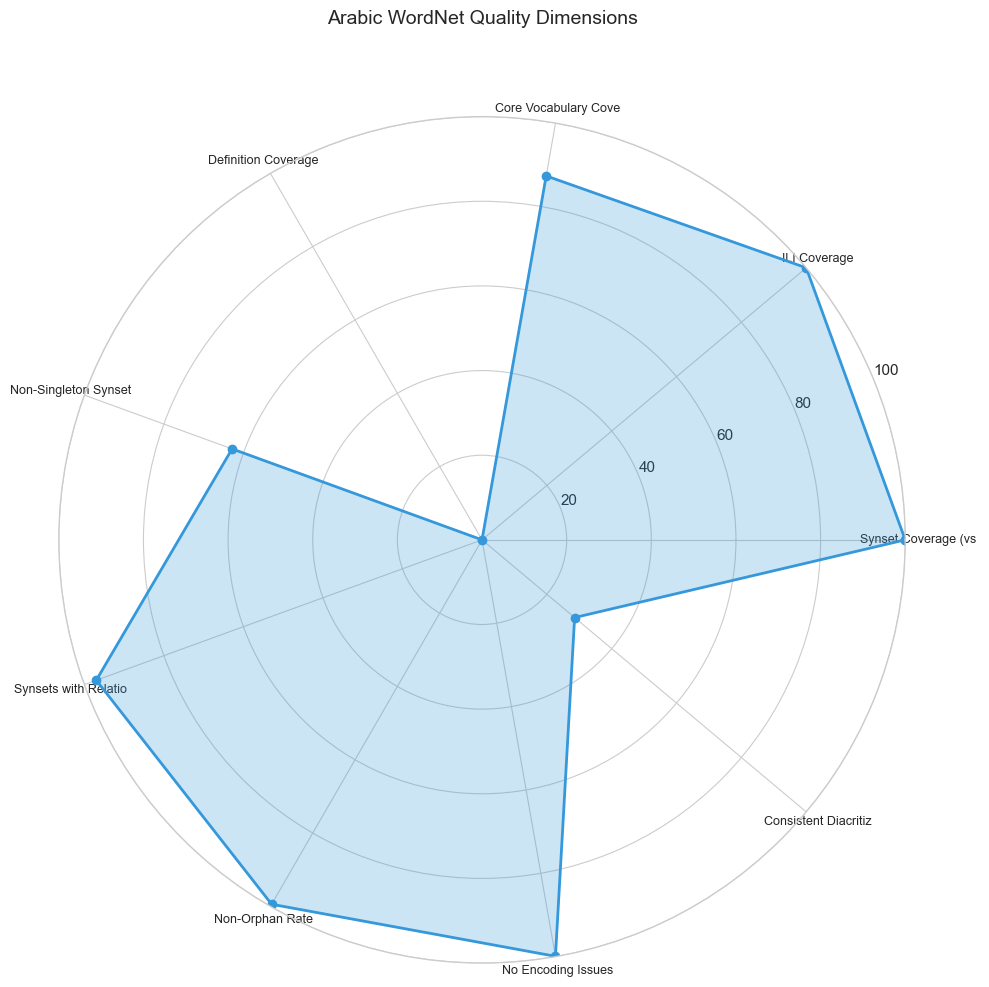

In [41]:
# Radar chart visualization
import matplotlib.pyplot as plt
import numpy as np

# Flatten metrics for radar chart
labels = []
values = []
for category, metrics in quality_metrics.items():
    for name, value in metrics.items():
        labels.append(name[:20])  # Truncate long names
        values.append(min(value, 100))  # Cap at 100%

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop
values += values[:1]

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.plot(angles, values, 'o-', linewidth=2, color='#3498db')
ax.fill(angles, values, alpha=0.25, color='#3498db')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=9)
ax.set_ylim(0, 100)
ax.set_title('Arabic WordNet Quality Dimensions', size=14, y=1.1)

plt.tight_layout()
plt.savefig(EXPORT_DIR / 'quality_radar.png', dpi=150, bbox_inches='tight')
plt.show()

## Section 22: Recommendations

In [42]:
# Generate recommendations based on analysis
print("Recommendations")
print("=" * 60)

recommendations = []

# Coverage recommendations
if summary_metrics['ili_coverage_pct'] < 100:
    recommendations.append({
        'Priority': 'High',
        'Category': 'Coverage',
        'Issue': f"{100 - summary_metrics['ili_coverage_pct']:.1f}% synsets lack ILI mapping",
        'Recommendation': 'Add ILI links for all synsets to enable cross-lingual functionality'
    })

if def_stats['with_arabic_def'] / len(arb_synsets) < 0.5:
    recommendations.append({
        'Priority': 'High',
        'Category': 'Completeness',
        'Issue': f"Only {def_stats['with_arabic_def']/len(arb_synsets)*100:.1f}% have Arabic definitions",
        'Recommendation': 'Add Arabic definitions to improve usability for Arabic speakers'
    })

if len(singleton_synsets) / len(arb_synsets) > 0.3:
    recommendations.append({
        'Priority': 'Medium',
        'Category': 'Richness',
        'Issue': f"{len(singleton_synsets)/len(arb_synsets)*100:.1f}% synsets have only one word",
        'Recommendation': 'Enrich synsets with additional synonyms'
    })

if len(large_synsets) > 50:
    recommendations.append({
        'Priority': 'Medium',
        'Category': 'Structure',
        'Issue': f"{len(large_synsets)} synsets have 10+ words (potential over-lumping)",
        'Recommendation': 'Review large synsets for potential splitting'
    })

highly_poly = sum(1 for w in arb.words() if len(w.senses()) >= 10)
if highly_poly > 100:
    recommendations.append({
        'Priority': 'Medium',
        'Category': 'Granularity',
        'Issue': f"{highly_poly} words have 10+ senses (potential over-splitting)",
        'Recommendation': 'Review highly polysemous words for sense merging opportunities'
    })

if len(encoding_issues) > 0:
    recommendations.append({
        'Priority': 'Low',
        'Category': 'Data Quality',
        'Issue': f"{len(encoding_issues)} encoding/formatting issues detected",
        'Recommendation': 'Clean up encoding issues for data consistency'
    })

# Display recommendations
for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. [{rec['Priority']}] {rec['Category']}")
    print(f"   Issue: {rec['Issue']}")
    print(f"   Recommendation: {rec['Recommendation']}")

rec_df = pd.DataFrame(recommendations)
export_df(rec_df, 'recommendations.csv')

Recommendations

1. [High] Completeness
   Issue: Only 0.0% have Arabic definitions
   Recommendation: Add Arabic definitions to improve usability for Arabic speakers

2. [Medium] Richness
   Issue: 37.2% synsets have only one word
   Recommendation: Enrich synsets with additional synonyms

3. [Medium] Structure
   Issue: 782 synsets have 10+ words (potential over-lumping)
   Recommendation: Review large synsets for potential splitting

4. [Medium] Granularity
   Issue: 512 words have 10+ senses (potential over-splitting)
   Recommendation: Review highly polysemous words for sense merging opportunities

5. [Low] Data Quality
   Issue: 14 encoding/formatting issues detected
   Recommendation: Clean up encoding issues for data consistency
Exported: exports/recommendations.csv (5 rows)


PosixPath('exports/recommendations.csv')

## Section 23: Export All Reports

In [43]:
# Generate master summary report
summary_report = f"""
# Arabic WordNet Quality Evaluation Report

**Generated:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## Lexicon Information
- **ID:** {arb_lex.id}
- **Version:** {arb_lex.version}
- **Label:** {arb_lex.label}
- **Language:** {arb_lex.language}

## Summary Statistics
| Metric | Value |
|--------|-------|
| Total Words | {summary_metrics['total_words']:,} |
| Total Senses | {summary_metrics['total_senses']:,} |
| Total Synsets | {summary_metrics['total_synsets']:,} |
| Nouns | {summary_metrics['words_n']:,} words, {summary_metrics['synsets_n']:,} synsets |
| Verbs | {summary_metrics['words_v']:,} words, {summary_metrics['synsets_v']:,} synsets |
| Adjectives | {summary_metrics['words_a']:,} words, {summary_metrics['synsets_a']:,} synsets |
| Adverbs | {summary_metrics['words_r']:,} words, {summary_metrics['synsets_r']:,} synsets |

## Quality Indicators
| Indicator | Value |
|-----------|-------|
| ILI Coverage | {summary_metrics['ili_coverage_pct']:.1f}% |
| Definition Coverage | {def_stats['with_arabic_def']/len(arb_synsets)*100:.1f}% |
| Core Vocabulary Coverage | {found_count/len(swadesh_arabic)*100:.1f}% |
| Singleton Synsets | {len(singleton_synsets)/len(arb_synsets)*100:.1f}% |

## Issues Found
- Structural issues: {len(issues)}
- Encoding issues: {len(encoding_issues)}
- ILI mapping issues: {len(ili_issues)}
- Alignment issues: {len(alignment_issues)}

## Recommendations
"""

for i, rec in enumerate(recommendations, 1):
    summary_report += f"\n{i}. **[{rec['Priority']}]** {rec['Issue']}\n"
    summary_report += f"   - {rec['Recommendation']}\n"

summary_report += """
## Exported Files
"""

# List all exported files
for f in sorted(EXPORT_DIR.glob('*')):
    size = f.stat().st_size
    summary_report += f"- `{f.name}` ({size:,} bytes)\n"

# Save report
with open(EXPORT_DIR / 'quality_summary_report.md', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print("Master summary report exported to: exports/quality_summary_report.md")
print("\n" + "=" * 60)
print("All exports completed!")
print("=" * 60)
print(f"\nExported files:")
for f in sorted(EXPORT_DIR.glob('*')):
    print(f"  - {f.name}")

Master summary report exported to: exports/quality_summary_report.md

All exports completed!

Exported files:
  - alignment_issues.csv
  - annotation_guidelines.md
  - completeness_audit.csv
  - coverage_comparison.png
  - coverage_summary.csv
  - definition_samples.csv
  - domain_coverage.csv
  - encoding_issues.csv
  - executive_summary.png
  - highly_polysemous_words.csv
  - morphological_analysis.csv
  - polysemy_distribution.png
  - quality_radar.png
  - quality_summary_report.md
  - recommendations.csv
  - relation_statistics.csv
  - review_sample_adjectives.csv
  - review_sample_adverbs.csv
  - review_sample_full.json
  - review_sample_nouns.csv
  - review_sample_verbs.csv
  - structural_issues.csv
  - synset_samples_for_review.csv
  - taxonomy_depth.png
  - translation_samples_for_review.csv
  - vocabulary_gaps.csv


In [44]:
# Create ZIP archive of all exports
import shutil

zip_path = shutil.make_archive(
    'arabic_wordnet_evaluation_exports',
    'zip',
    EXPORT_DIR
)

print(f"\nZIP archive created: {zip_path}")
print(f"Size: {os.path.getsize(zip_path):,} bytes")


ZIP archive created: /Users/salahmac/Desktop/MLProjects/wn-project/wn/notebooks/arabic_wordnet_evaluation_exports.zip
Size: 541,977 bytes


---

## Evaluation Complete

This notebook has analyzed the Arabic WordNet across multiple quality dimensions:

1. **Coverage** - Lexical, domain, and core vocabulary coverage
2. **Structure** - Taxonomy, relations, and consistency
3. **Linguistic Quality** - Polysemy, synonyms, definitions, morphology
4. **Cross-Lingual Alignment** - ILI mapping and translation accuracy
5. **Data Quality** - Duplicates, encoding, completeness

All results have been exported to the `exports/` directory for offline review and annotation.

### Next Steps
1. Review the `quality_summary_report.md` for an overview
2. Use the stratified samples (`review_sample_*.csv`) for manual quality assessment
3. Address issues in priority order based on recommendations
4. Re-run this evaluation after making improvements to track progress